# Fundamentals of Artificial Intelligence Programme (2024/25 Q1)
## Multiobjective optimization for decision support
Dr. Jazmin Zatarain Salazar

In this assignment, we use two python libraries, one for exploratory modeling analysis [The EMA workbench](https://emaworkbench.readthedocs.io/en/latest/) and one for multiobjective optimization [Project Platypus](https://platypus.readthedocs.io/en/latest/), you can install both with pip as follows:

In [6]:
!pip install ema_workbench platypus-opt

# The Lake model

The goal of this assignment is to demonstrate the use of multiobjective evolutionary optimization, to learn how to visualize and interpret the optimization results, and to use performance metrics to assess the results obtained via multiobjective evolutionary optimization.  We will use the lake problem as a test case, this is a classic problem initially developed by Carpenter et al. (1999) where the population of a city has to decide the amount of annual pollution it will release into a lake.  In this exercise, we will use the adapted version in [Quinn et al. 2017](https://www-sciencedirect-com.tudelft.idm.oclc.org/science/article/pii/S1364815216302250?casa_token=wBdtfic9L4YAAAAA:Oum4EU3ob7bgKoCK2WhEFfOfIGUrsXpvp7PSvnRyMbDSF8lHXdf48H5hMe6d0DS1zChv5IhO) were the problem is defined as a state-based control problem (where actions are a function of the state of the system).  In this case, the 'action' is the Phosphorous (P) emissions which are optimized to balance the economic benefits and the quality of the lake. Since this is a multi-objective problem,  we need a flexible function to map the states to actions, so we use radial basis functions to parameterize the emission control policies. In fact, the MOEA will search for the optimal radii, centers and weights that yield good performance for the objectives of the lake model described below.  See the paper for more details about the problem formulation.

The model is defined by the following equation:

$
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
$

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable where $a_t \in [0,0.1]$.

There are four outcomes of interest. The first is the average concentration of phosphor in the lake.

$
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t
$

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time.
The second objective is the economic benefit derived from polluting the lake defined as the discounted benefit of pollution minus the costs of having a polluted lake.

$ f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t$

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate.

$ f_{inertia} = \frac{1}{\left\vert{T}\right\vert-1}\sum \limits_{t=1}^{\left\vert{T}\right\vert}I(|a_{t}-a_{t-1} |>\tau)$

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

$
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} )
$

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values.

# Lake model implementation in python

In [15]:
import math
import numpy as np
from scipy.optimize import brentq


def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    '''

    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1

    Returns
    -------
    float

    note:: w2 = 1 - w1

    '''

    rule = w1 * (abs(xt - c1) / r1) ** 3 + (1 - w1) * (abs(xt - c2) / r2) ** 3
    at1 = max(rule, 0.01)
    at = min(at1, 0.1)

    return at


# def lake_model(b=0.42, q=2.0, mean=0.02,
#                stdev=0.001, delta=0.98, alpha=0.4,
#                nsamples=100, myears=100, c1=0.25,
#                c2=0.25, r1=0.5, r2=0.5,
#                w1=0.5, seed=123):

# adapted from the following request
def lake_model(b=0.42, q=2.0, mean=0.02,
               stdev=0.001, delta=0.98, alpha=0.41,
               nsamples=150, myears=100,
               c1=0.25, c2=0.25, r1=0.5, r2=0.5,
               w1=0.5, seed=123):
    '''runs the lake model for nsamples stochastic realisation using
    specified random seed.

    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    delta : float
            future utility discount rate
    alpha : float
            utility from pollution
    nsamples : int, optional
    myears : int, optional
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    seed : int, optional
           seed for the random number generator

    Returns
    -------
    tuple

    '''
    np.random.seed(seed)
    Pcrit = brentq(lambda x: x ** q / (1 + x ** q) - b * x, 0.01, 1.5)

    X = np.zeros((myears,))
    average_daily_P = np.zeros((myears,))
    reliability = 0.0
    inertia = 0
    utility = 0

    for _ in range(nsamples):
        X[0] = 0.0
        decision = 0.1

        decisions = np.zeros(myears, )
        decisions[0] = decision

        natural_inflows = np.random.lognormal(
            math.log(mean ** 2 / math.sqrt(stdev ** 2 + mean ** 2)),
            math.sqrt(math.log(1.0 + stdev ** 2 / mean ** 2)),
            size=myears)

        for t in range(1, myears):
            # here we use the decision rule
            decision = max(w1 * (abs(X[t - 1] - c1) / r1) ** 3 + (1 - w1) * (abs(X[t - 1] - c2) / r2) ** 3, 0.01)
            decision = min(decision, 0.1)
            decisions[t] = decision

            X[t] = (1 - b) * X[t - 1] + X[t - 1] ** q / (1 + X[t - 1] ** q) + decision + natural_inflows[t - 1]
            average_daily_P[t] += X[t] / nsamples
            if isinstance(average_daily_P[t], (bool, np.bool_)):
                average_daily_P[t] = float(average_daily_P[t])
            # print(f"average_daily_P[{t}]: {average_daily_P[t]}, type: {type(average_daily_P[t])}")


        reliability += np.sum(X < Pcrit) / (nsamples * myears)
        inertia += np.sum(np.absolute(np.diff(decisions)
                                      < 0.02)) / (nsamples * myears)
        utility += np.sum(alpha * decisions * np.power(delta,
                                                       np.arange(myears))) / nsamples
    max_P = np.max(average_daily_P)
    # if isinstance(max_P, (bool, np.bool_)):
    #     max_P = 0.0  #

    # print(f"max_P: {max_P}, type: {type(max_P)}")


    return max_P, utility, inertia, reliability

## 1. Connecting the lake model with the EMA workbench.

Given the Python implementation of the lake problem above, adapt the code and connect it to the EMA workbench
using the following lever ranges and uncertainty ranges:

|Levers 	|Range	        |Default value|
|-----------|--------------:|------------:|
|$r1$    	|0.0 – 2.0	    |0.5          |
|$r2$	    |0.0 – 2.0 	    |0.5.         |
|$c1$      	|-2 – 2	        |0.25         |
|$c2$	    |-2 – 2	        |0.25         |
|$w1$	    |0.0-1.0    	|0.5          |


|Uncertainties	|Range	        |Default value|
|---------------|--------------:|------------:|
|$\mu$    	    |0.01 – 0.05	|0.02         |
|$\sigma$	    |0.001 – 0.005 	|0.0017       |
|$b$      	    |0.1 – 0.45	    |0.42         |
|$q$	        |2 – 4.5	    |2            |
|$\delta$	    |0.93 – 0.99	|0.98         |
    
You can follow [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/directed-search.html)for guidance.

The outcomes in the EMA workbench refers to the objectives of the problem, in this case we have four. 1) maximum Phosphorous (to be minimized) 2) utility (to be maximized) 3) intertia (to be maximized), and reliability (to be maximized).  Use an alpha value of 0.41, with number of samples= 150, and number of years = 100.

In [16]:
# target:
# Maximum phosphorus concentration: should be minimized, because higher phosphorus concentration means deterioration of lake water quality.
# Economic benefits: should be maximized to achieve long-term economic benefits through pollution control strategies.
# Inertia: should be maximized to maintain consistency and stability of pollution policies between years.
# Reliability: should be maximized to ensure that lake pollution is below the critical value in more years to ensure environmental safety.


from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator)

lakemodel = Model('lakemodel', function=lake_model)

# Levers
lakemodel.levers = [RealParameter('r1', 0.0, 2.0),
                    RealParameter('r2', 0.0, 2.0),
                    RealParameter('c1', -2.0, 2.0),
                    RealParameter('c2', -2.0, 2.0),
                    RealParameter('w1', 0.0, 1.0)]

# Uncertainties
lakemodel.uncertainties = [RealParameter('mean', 0.01, 0.05),
                           RealParameter('stdev', 0.001, 0.005),
                           RealParameter('b', 0.1, 0.45),
                           RealParameter('q', 2, 4.5),
                           RealParameter('delta', 0.93, 0.99)]

# Outcomes
lakemodel.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

## 2. How would you introduce a constrain within the optimization to reflect a desired performance threshold for a given objective?

You don't actually have to perform this step, simply specify how you would go about establishing a constraint in the optimization formulation, in such a way that it only finds solutions with maximum pollution (max phosphorous) of 0.85.

In [20]:
# add a constraint to the optimization problem
from ema_workbench import Constraint
constraints = [Constraint("max pollution", outcome_names="max_P", function=lambda x: max(0.85, x))]


# 3.  Run the optimization and track the performance metrics

Tip: the EMA Workbench uses [Platypus](https://github.com/Project-Platypus/Platypus) to run the optimization via the evaluator class, you can also collect metrics during runtime specifying the convergence option. Below is a sample snippet on how to run the optimization and collect performance metrics during runtime.

In [21]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)


convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[1,1.01,1.01,1.01]),
                       EpsilonProgress()]


ema_logging.log_to_stderr(ema_logging.INFO)


with MultiprocessingEvaluator(lakemodel) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=10000,
        searchover='levers',
        epsilons=[0.1, 0.1, 0.01, 0.1],
        convergence=convergence_metrics,
        constraints=constraints)



[MainProcess/INFO] pool started with 2 workers


  0%|                                                | 0/10000 [00:00<?, ?it/s]

  1%|▍                                     | 100/10000 [00:09<15:17, 10.79it/s]

  2%|▊                                     | 200/10000 [00:17<14:17, 11.43it/s]

  3%|█▏                                    | 300/10000 [00:25<13:33, 11.93it/s]

  4%|█▌                                    | 400/10000 [00:34<13:53, 11.52it/s]

  5%|█▉                                    | 500/10000 [00:43<13:48, 11.46it/s]

  6%|██▎                                   | 600/10000 [00:51<13:25, 11.66it/s]

  7%|██▋                                   | 700/10000 [01:00<13:32, 11.44it/s]

  8%|███                                   | 800/10000 [01:10<13:50, 11.07it/s]

  9%|███▍                                  | 900/10000 [01:17<12:41, 11.95it/s]

  9%|███▍                                  | 900/10000 [01:28<12:41, 11.95it/s]

 10%|███▋                                 | 1000/10000 [01:2

# 4.  Selecting the objectives.

The outputs from the optimization runs will contain the decision variables (i.e. the parameters of the radial basis functions) and objectives combined.  Create a data structure that only contains the objective values without the decision variables.

Tip: each row in the output matrix represents a different solution with it's obective values, the first columns are the decision variables and the last columns are the objective values.

In [27]:
results

,r1,r2,c1,c2,w1,max_P,utility,inertia,reliability
0,0.475550,0.976891,0.206675,0.183765,0.942480,0.097738,0.267078,0.990000,1.000000
1,0.085196,1.238544,0.240845,-0.261639,0.773910,0.522222,0.729131,0.987867,0.866733
2,0.085196,1.499870,0.240801,-0.405092,0.825415,0.838874,0.910375,0.985933,0.725267
3,0.085196,0.804180,0.242007,-0.012470,0.847954,0.481739,0.707849,0.743333,0.883867
4,0.086045,1.238544,0.240845,-0.261639,0.773910,0.356860,0.637278,0.989067,0.939400
5,0.456780,1.499182,0.327283,-0.298367,0.944601,0.194646,0.534778,0.990000,1.000000
6,0.085196,0.709425,0.240825,-0.062171,0.820034,0.659329,0.807812,0.986800,0.805200


In [23]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,5,100
2,0.0,6,1100
3,0.0,6,2100
4,0.0,6,3100
5,0.0,6,4100
6,0.0,6,5100
7,0.0,10,6100
8,0.0,16,7100
9,0.0,24,8100


In [24]:
import pandas as pd

objective_columns = ['max_P', 'utility', 'inertia', 'reliability']


objectives_df = results[objective_columns]


print(objectives_df)


      max_P   utility   inertia  reliability
0  0.097738  0.267078  0.990000     1.000000
1  0.522222  0.729131  0.987867     0.866733
2  0.838874  0.910375  0.985933     0.725267
3  0.481739  0.707849  0.743333     0.883867
4  0.356860  0.637278  0.989067     0.939400
5  0.194646  0.534778  0.990000     1.000000
6  0.659329  0.807812  0.986800     0.805200


In [26]:
objectives_df.to_csv('objectives_only.csv', index=False)
results.to_csv('results.csv', index=False)
convergence.to_csv('convergence.csv', index=False)

# 5.  Visualizing the results.

Present visually the results of the Pareto optimal solutions (in the objective space), feel free to be creative! Provide a brief discussion the results, are there any tradeoffs observed?

Tip: If you need inspiration check out the EMA workbench [parcoords](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html).

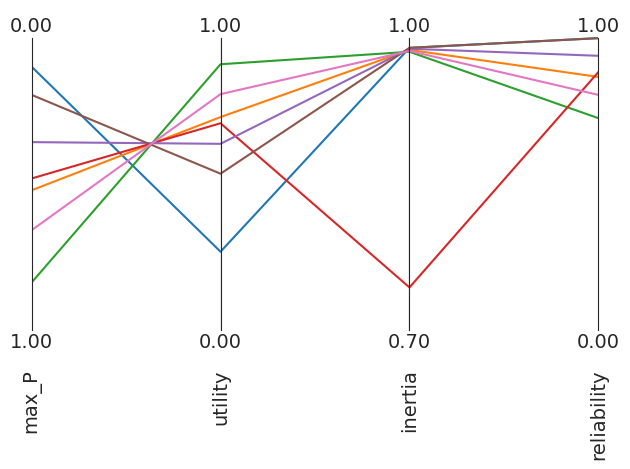

In [29]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

data = objectives_df


limits = parcoords.get_limits(data)
limits.loc[0, ['max_P', 'utility', 'reliability']] = 0
limits.loc[0, ['inertia']] = 0.7
limits.loc[1, ['max_P', 'utility', 'inertia', 'reliability']] = 1


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')


plt.show()

Yes, the parallel coordinates plot reveals several trade-offs among the objectives in the multi-objective optimization problem. Specifically, it shows that reducing maximum phosphorus levels (Max_P) often compromises utility and reliability. Additionally, there's an observable trade-off between inertia and reliability, suggesting that efforts to maintain the status quo (inertia) may adversely affect the reliability of the system.

## 6. Establishing a performance threshold.

Show visually only the solutions from the Pareto set that yield a reliability above 80%, and briefly discuss the results.

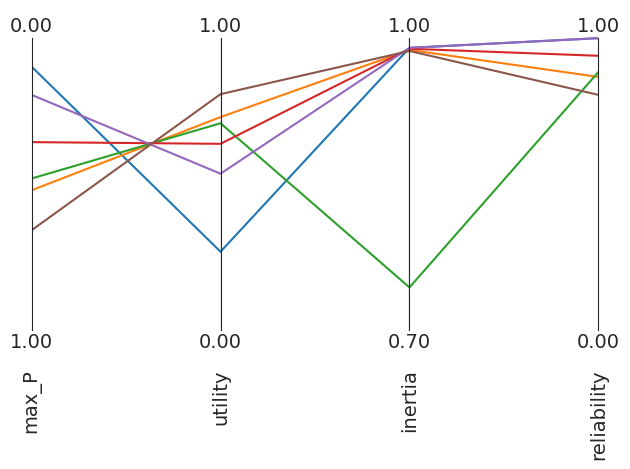

In [31]:
import plotly.express as px


filtered_data = objectives_df[objectives_df['reliability'] > 0.8]


limits = parcoords.get_limits(data)
limits.loc[0, ['max_P', 'utility', 'reliability']] = 0
limits.loc[0, ['inertia']] = 0.7
limits.loc[1, ['max_P', 'utility', 'inertia', 'reliability']] = 1


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(filtered_data)
paraxes.invert_axis('max_P')


plt.show()


**BY GPTs so needed to be adapted:**
Variation Across Objectives: The plot vividly illustrates how different solutions optimize the balance between Max Phosphorus, Utility, Inertia, and Reliability. Each line represents a distinct solution, showing its performance across these four objectives.

Max Phosphorus vs. Reliability: Solutions with the lowest phosphorus levels do not necessarily correspond to the highest reliability, indicating a trade-off between minimizing environmental impact and maintaining system reliability.
Utility and Inertia: There is a visible tension between Utility and Inertia, where higher utility scores tend to align with lower inertia values. This might suggest that more dynamic solutions, which potentially involve more frequent changes or adjustments (lower inertia), could yield higher utility.
Clustering of Solutions:

The solutions that achieve higher reliability (closer to 1) often display a diverse range of performances in terms of Max Phosphorus and Utility, showing that achieving high reliability is possible with various strategic configurations.
There's a notable concentration of solutions with high Utility and moderate to high Reliability, which could be indicative of a sweet spot for balancing these objectives effectively.
Interpretation for Decision Making:

This visualization is invaluable for decision-makers aiming to understand the spectrum of viable options and the necessary compromises associated with different environmental and operational strategies.
Decisions can be guided by priorities: if minimizing environmental impact (lower Max Phosphorus) is more critical, some decrease in utility and reliability might be acceptable; conversely, if operational performance (high Utility) is crucial, some environmental trade-offs might be necessary.
In summary, the graph not only highlights the inherent trade-offs and synergies among the objectives but also provides a strategic visualization tool that can guide the selection of optimal solutions based on specific performance thresholds and priorities.

# 7. Performance metrics

Show in a dataframe the results from the metrics (convergence) collected during the optimization. Plot the metrics (e.g hypervolume or epsilon progress) as a function of the number of function evaluations (nfe). Provide a brief discussion of the results.

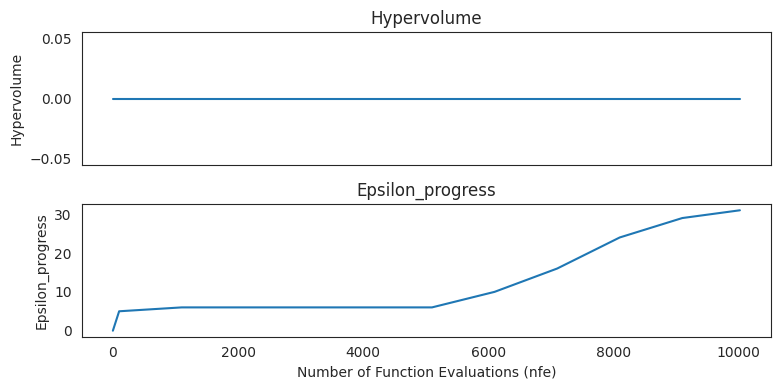

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("white")

# List of possible metrics we want to check if they exist in the DataFrame
possible_metrics = ['hypervolume', 'epsilon_progress', 'generational_distance', 'epsilon_indicator', 'inverted_gd', 'spacing']

# Filter out the metrics that exist in the DataFrame
available_metrics = [metric for metric in possible_metrics if metric in convergence.columns]

# Determine the number of plots based on available metrics
num_plots = len(available_metrics)

# Create subplots dynamically based on the number of available metrics
fig, axes = plt.subplots(nrows=num_plots, figsize=(8, 2 * num_plots), sharex=True)

# If only one metric available, wrap the axes object in a list
if num_plots == 1:
    axes = [axes]

# Plotting each available metric
for ax, metric in zip(axes, available_metrics):
    ax.plot(convergence['nfe'], convergence[metric], label=metric)
    ax.set_title(metric.capitalize())
    ax.set_ylabel(metric.capitalize())

# Set common x-axis label
axes[-1].set_xlabel('Number of Function Evaluations (nfe)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Extra credit: Visualize the phosphorous release from the policy with the highest reliability.   If you plot phosphorous release as a function of time, what do you observe?

In [38]:
def lake_model(b=0.42, q=2.0, mean=0.02, stdev=0.001, delta=0.98, alpha=0.41,
               nsamples=150, myears=100, c1=0.25, c2=0.25, r1=0.5, r2=0.5, w1=0.5, seed=123):
    """
    Runs the lake model simulation for a given set of parameters and policies.

    Parameters:
    - b, q, mean, stdev, delta, alpha : float, environmental and economic parameters.
    - nsamples : int, number of samples for stochastic realization.
    - myears : int, number of years to simulate.
    - c1, c2, r1, r2, w1 : float, parameters for the decision-making policy.
    - seed : int, random seed for reproducibility.

    Returns:
    - tuple (float, float, float, float, np.array), containing max P, utility, inertia, reliability,
      and phosphorous release over time for visualization.
    """
    np.random.seed(seed)
    Pcrit = brentq(lambda x: x ** q / (1 + x ** q) - b * x, 0.01, 1.5)

    X = np.zeros((myears,))  # Pollution levels
    phosphorous_release_over_time = np.zeros((myears,))  # Store phosphorous release values for each year
    reliability = 0.0
    inertia = 0
    utility = 0

    for _ in range(nsamples):
        X[0] = 0.0  # Start with no pollution
        decision = 0.1  # Initial decision

        decisions = np.zeros(myears,)
        decisions[0] = decision
        natural_inflows = np.random.lognormal(math.log(mean ** 2 / math.sqrt(stdev ** 2 + mean ** 2)),
                                              math.sqrt(math.log(1.0 + stdev ** 2 / mean ** 2)),
                                              size=myears)

        for t in range(1, myears):
            decision = get_antropogenic_release(X[t - 1], c1, c2, r1, r2, w1)
            decisions[t] = decision
            X[t] = (1 - b) * X[t - 1] + X[t - 1] ** q / (1 + X[t - 1] ** q) + decision + natural_inflows[t - 1]
            phosphorous_release_over_time[t] += decision / nsamples  # Accumulate average release

        reliability += np.sum(X < Pcrit) / (nsamples * myears)
        inertia += np.sum(np.absolute(np.diff(decisions) < 0.02)) / (nsamples * myears)
        utility += np.sum(alpha * decisions * np.power(delta, np.arange(myears))) / nsamples

    max_P = np.max(X)

    return max_P, utility, inertia, reliability, phosphorous_release_over_time


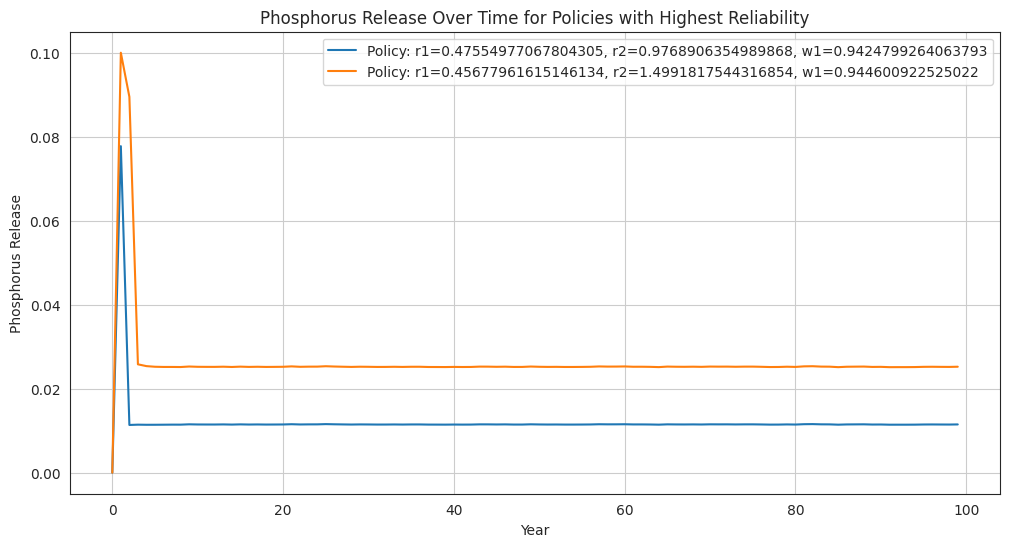

In [42]:
# Identify the policy with the highest reliability, and it's not only one
max_reliability = results['reliability'].max()
highest_reliability_policies = results[results['reliability'] == max_reliability]

plt.figure(figsize=(12, 6))

# 对每个最高可靠性的策略运行模型并绘制
for _, policy in highest_reliability_policies.iterrows():
    max_P, utility, inertia, reliability, phosphorous_release = lake_model(
        c1=policy['c1'],
        c2=policy['c2'],
        r1=policy['r1'],
        r2=policy['r2'],
        w1=policy['w1']
    )

    # 绘制磷释放量时间序列
    plt.plot(np.arange(100), phosphorous_release, label=f'Policy: r1={policy["r1"]}, r2={policy["r2"]}, w1={policy["w1"]}')

plt.xlabel('Year')
plt.ylabel('Phosphorus Release')
plt.title('Phosphorus Release Over Time for Policies with Highest Reliability')
plt.legend()
plt.grid(True)
plt.show()

I want aknowledge my colleagues Jan Kwakkel and Giacomo Marangoni for their valuable contributions to this assignment.

**From GPT**
1. Initial peak of phosphorus release
The figure shows that both strategies have a peak of phosphorus release in the initial stage, which may indicate that a higher phosphorus release strategy was implemented at the beginning of the model. This peak quickly decreased, indicating that adjustments may have been quickly implemented to reduce phosphorus emissions.

2. Rapid stabilization of phosphorus release
After the initial peak, the phosphorus release of the two strategies quickly reached a stable state, which lasted until the end of the simulation. This rapid stabilization phenomenon may be due to the adjustment of decision rules in the model or the influence of natural phosphorus cycle processes.

3. Steady-state differences of different strategies
The two curves show slightly different levels after stabilization, and the phosphorus release of the orange curve is slightly higher than that of the blue curve. This indicates that different strategy parameters (r1, r2, w1, etc.) may affect the final stable level of phosphorus release.

4. Long-term reliability
Since these strategies were selected as having the highest reliability, their long-term performance shows the effectiveness of phosphorus release control. There is no large fluctuation or increase in phosphorus release, indicating that these strategies can effectively control phosphorus pollution and maintain the stability of lake ecology.